In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install keras==2.4.3
# !pip install tensorflow==2.4.1

In [3]:
!pip install keras-multi-head
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14993 sha256=f87f5265db70b9c133f944df2ef47385db6cacf69c9fa559d0da4b506d0630fb
  Stored in directory: /root/.cache/pip/wheels/86/aa/3c/9d15d24005179dae08ff291ce99c754b296347817d076fd9fb
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=e543c55858a41d19d8c83beb0e3a70484e0abccbb182bb0094c0dc308275bbbe
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-multi-head keras-self-attention
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# # For Weights and Biases
# !pip install wandb

In [4]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [5]:
# import wandb
# from wandb.keras import WandbCallback

# # Login to W&B
# wandb.login()

In [6]:
%cd /content/drive/MyDrive/Colab_Notebooks/FINAL_THESIS_PROJECT/codes

/content/drive/.shortcut-targets-by-id/1-TsISowGVH-c2pg1SMS88BRnBWd9B3c0/FINAL_THESIS_PROJECT/codes


In [7]:
from features import *
from helper import *

In [8]:
code_path = "/content/drive/MyDrive/Colab_Notebooks/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [9]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [10]:
mocap_rot = []

for ses_mod in data2:
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))  
    x_rot[np.isnan(x_rot)]=0
    mocap_rot.append( x_rot )
    
mocap_rot = np.array(mocap_rot)
mocap_rot = mocap_rot.reshape(-1,200,165,1)
mocap_rot.shape
# print(type(mocap_rot))

(4936, 200, 165, 1)

In [11]:
Y=[]
for ses_mod in data2:
  if ses_mod['emotion'] == 'neu':
    Y.append(0)
  elif ses_mod['emotion'] == 'ang':
    Y.append(1)
  elif ses_mod['emotion'] == 'exc':
    Y.append(2)
  elif ses_mod['emotion'] == 'sad':
    Y.append(3)

Y = np.array(Y)
print(type(Y))
Y[0],Y[1], Y[2]

<class 'numpy.ndarray'>


(0, 0, 0)

In [12]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [13]:
xtrain_mocap_rot = mocap_rot[:3838]
xtest_mocap_rot = mocap_rot[3838:]
ytrain_mocap_rot = Y[:3838]
ytest_mocap_rot = Y[3838:]

print(xtrain_mocap_rot.shape)
print(xtest_mocap_rot.shape)

print(ytrain_mocap_rot.shape)
print(ytest_mocap_rot.shape)

(3838, 200, 165, 1)
(1098, 200, 165, 1)
(3838,)
(1098,)


#**Model_Head 1A**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention

def create_model_1():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)
    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_1()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 165, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 82, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 82, 128)      295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 41, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 41, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 41, 128)       147584

In [17]:
model.compile(
  optimizer=keras.optimizers.SGD(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [18]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=100, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/100
39/39 [==============================] - 51s 795ms/step - loss: 1.4983 - acc: 0.2798 - val_loss: 1.3729 - val_acc: 0.2996
Epoch 2/100
39/39 [==============================] - 25s 640ms/step - loss: 1.3757 - acc: 0.3025 - val_loss: 1.3778 - val_acc: 0.2942
Epoch 3/100
39/39 [==============================] - 26s 656ms/step - loss: 1.3572 - acc: 0.3251 - val_loss: 1.3652 - val_acc: 0.3005
Epoch 4/100
39/39 [==============================] - 26s 677ms/step - loss: 1.3492 - acc: 0.3280 - val_loss: 1.4754 - val_acc: 0.2077
Epoch 5/100
39/39 [==============================] - 27s 693ms/step - loss: 1.3765 - acc: 0.3041 - val_loss: 1.3201 - val_acc: 0.4035
Epoch 6/100
39/39 [==============================] - 26s 676ms/step - loss: 1.3231 - acc: 0.3565 - val_loss: 1.3232 - val_acc: 0.3652
Epoch 7/100
39/39 [==============================] - 26s 675ms/step - loss: 1.3278 - acc: 0.3704 - val_loss: 1.3193 - val_acc: 0.3197
Epoch 8/100
39/39 [==============================] - 27s 690ms

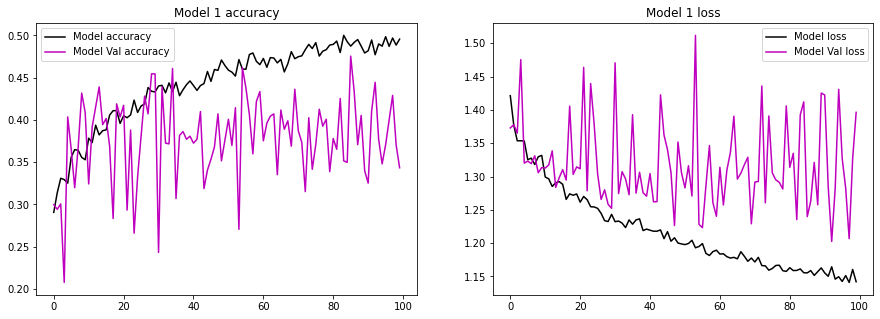

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [20]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [21]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.16639 dan Training Accuracy 47.66%
Validation Loss 1.39633 dan Validation Accuracy 34.34%


# **Model_Head 1B**

In [22]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_2():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [23]:
model = create_model_2()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 165, 256)     2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 82, 256)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 82, 256)      590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 41, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 41, 128)       295040    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 41, 128)       1475

In [24]:
model.compile(
  optimizer=keras.optimizers.SGD(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [25]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=100, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/100
39/39 [==============================] - 64s 1s/step - loss: 1.4296 - acc: 0.2087 - val_loss: 1.3952 - val_acc: 0.2996
Epoch 2/100
39/39 [==============================] - 45s 1s/step - loss: 1.4287 - acc: 0.2123 - val_loss: 1.3946 - val_acc: 0.2996
Epoch 3/100
39/39 [==============================] - 45s 1s/step - loss: 1.4279 - acc: 0.2119 - val_loss: 1.3940 - val_acc: 0.2996
Epoch 4/100
39/39 [==============================] - 45s 1s/step - loss: 1.4249 - acc: 0.1992 - val_loss: 1.3935 - val_acc: 0.2978
Epoch 5/100
39/39 [==============================] - 45s 1s/step - loss: 1.4256 - acc: 0.2049 - val_loss: 1.3931 - val_acc: 0.2969
Epoch 6/100
39/39 [==============================] - 45s 1s/step - loss: 1.4235 - acc: 0.2155 - val_loss: 1.3926 - val_acc: 0.2969
Epoch 7/100
39/39 [==============================] - 45s 1s/step - loss: 1.4206 - acc: 0.2109 - val_loss: 1.3922 - val_acc: 0.2769
Epoch 8/100
39/39 [==============================] - 45s 1s/step - loss: 1.4216 - a

KeyboardInterrupt: ignored

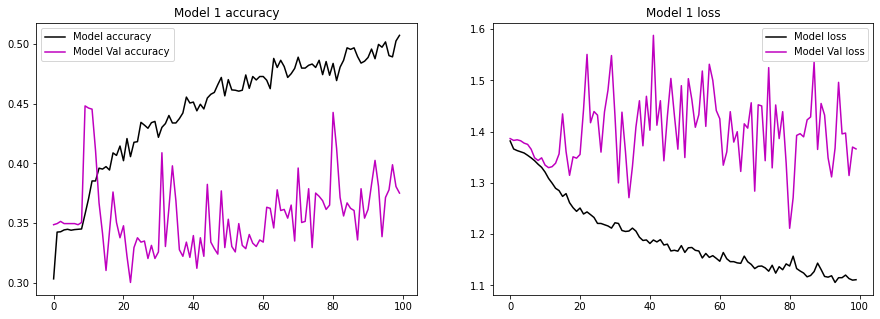

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [26]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [27]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.37451 dan Training Accuracy 34.58%
Validation Loss 1.37691 dan Validation Accuracy 34.88%


# **Model_Head 1C**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_3():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = SeqSelfAttention(attention_activation ='tanh')(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_3()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 165, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 82, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 82, 128)      295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 41, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 41, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 41, 128)       147584

In [19]:
model.compile(
  optimizer=keras.optimizers.RMSprop(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=7, epochs=100, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/100
549/549 [==============================] - 281s 498ms/step - loss: 1.3110 - acc: 0.3667 - val_loss: 1.3205 - val_acc: 0.4080
Epoch 2/100
549/549 [==============================] - 271s 493ms/step - loss: 1.2716 - acc: 0.4065 - val_loss: 1.4556 - val_acc: 0.3388
Epoch 3/100
549/549 [==============================] - 271s 493ms/step - loss: 1.2342 - acc: 0.4171 - val_loss: 1.6545 - val_acc: 0.2741
Epoch 4/100
549/549 [==============================] - 271s 493ms/step - loss: 1.2226 - acc: 0.4199 - val_loss: 1.5955 - val_acc: 0.2732
Epoch 5/100
549/549 [==============================] - 271s 493ms/step - loss: 1.1965 - acc: 0.4427 - val_loss: 1.4759 - val_acc: 0.2878
Epoch 6/100
549/549 [==============================] - 271s 493ms/step - loss: 1.1936 - acc: 0.4461 - val_loss: 1.5584 - val_acc: 0.2933
Epoch 7/100
549/549 [==============================] - 271s 494ms/step - loss: 1.1845 - acc: 0.4474 - val_loss: 1.8700 - val_acc: 0.2723
Epoch 8/100
549/549 [====================

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

#**Model_rot 1**

In [ ]:
def gru_model_rot1(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot1()
model.summary()

hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=5, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200, 1024)         3658752   
                                                                 
 gru_1 (GRU)                 (None, 200, 512)          2362368   
                                                                 
 gru_2 (GRU)                 (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
 activation_1 (Activation)   (None, 4)                 0

ValueError: ignored

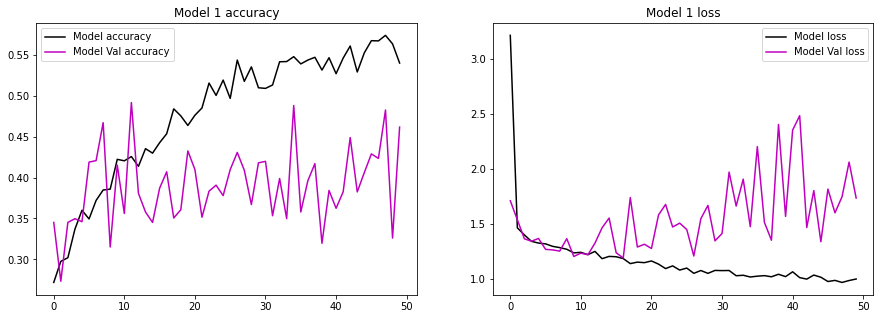

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.96962 dan Training Accuracy 58.21%
Validation Loss 1.73647 dan Validation Accuracy 46.17%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.79      0.30      0.43       933
         exc       0.74      0.64      0.69       742
         neu       0.58      0.45      0.51      1324
         sad       0.65      0.31      0.42       839

   micro avg       0.66      0.42      0.51      3838
   macro avg       0.69      0.42      0.51      3838
weighted avg       0.68      0.42      0.50      3838
 samples avg       0.42      0.42      0.42      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.40      0.01      0.02       170
         exc       0.48      0.85      0.62       299
         neu       0.55      0.41      0.47       384
         sad       0.00      0.00      0.00       245

   micro avg       0.51      0.38      0.43      1098
   macro avg       0.36      0.32      0.28      1098
weighted avg       0.39      0.38      0.33      1098
 samples avg       0.38      0.38      0.38      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


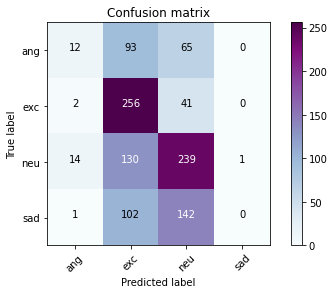

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 2**

In [ ]:
def gru_model_rot2(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot2()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 200, 1024)         3658752   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
gru_7 (GRU)                  (None, None, 512)         2362368   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
gru_8 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)              

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 45s 1s/step - loss: 4.1015 - accuracy: 0.2697 - val_loss: 1.4087 - val_accuracy: 0.2049
Epoch 2/50
39/39 [==============================] - 42s 1s/step - loss: 1.4101 - accuracy: 0.2974 - val_loss: 1.4489 - val_accuracy: 0.1949
Epoch 3/50
39/39 [==============================] - 43s 1s/step - loss: 1.3854 - accuracy: 0.3246 - val_loss: 1.3185 - val_accuracy: 0.3852
Epoch 4/50
39/39 [==============================] - 43s 1s/step - loss: 1.3837 - accuracy: 0.3154 - val_loss: 1.3640 - val_accuracy: 0.3288
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 1.3417 - accuracy: 0.3351 - val_loss: 1.3040 - val_accuracy: 0.4763
Epoch 6/50
39/39 [==============================] - 42s 1s/step - loss: 1.3223 - accuracy: 0.3832 - val_loss: 1.2446 - val_accuracy: 0.4845
Epoch 7/50
39/39 [==============================] - 42s 1s/step - loss: 1.3354 - accuracy: 0.3554 - val_loss: 1.2252 - val_accuracy: 0.4973
Epoch 8/50
39/39 [==

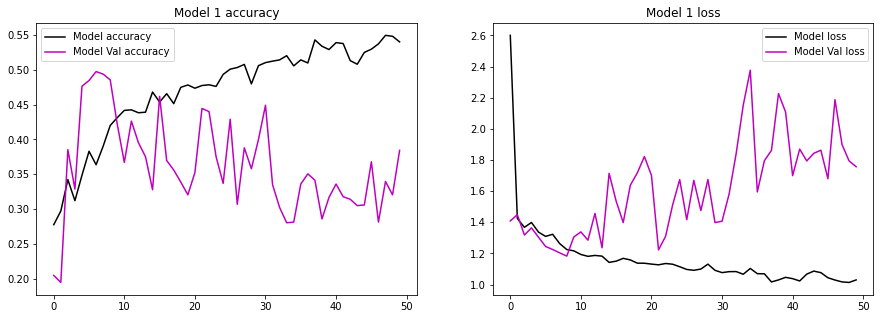

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.01332 dan Training Accuracy 55.60%
Validation Loss 1.75683 dan Validation Accuracy 38.43%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.71      0.35      0.47       933
         exc       0.77      0.55      0.64       742
         neu       0.57      0.31      0.40      1324
         sad       0.82      0.08      0.15       839

   micro avg       0.68      0.32      0.43      3838
   macro avg       0.72      0.32      0.41      3838
weighted avg       0.70      0.32      0.41      3838
 samples avg       0.32      0.32      0.32      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.08      0.12       170
         exc       0.47      0.85      0.60       299
         neu       0.59      0.15      0.24       384
         sad       0.00      0.00      0.00       245

   micro avg       0.47      0.30      0.36      1098
   macro avg       0.32      0.27      0.24      1098
weighted avg       0.37      0.30      0.27      1098
 samples avg       0.30      0.30      0.30      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


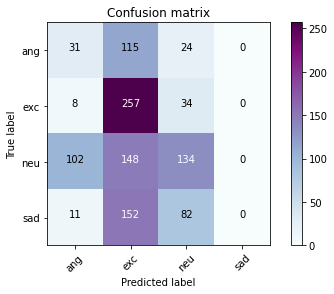

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 3**

In [ ]:
def gru_model_rot3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot3()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 86s 2s/step - loss: 5.6839 - accuracy: 0.2688 - val_loss: 1.3755 - val_accuracy: 0.2741
Epoch 2/50
39/39 [==============================] - 79s 2s/step - loss: 1.4262 - accuracy: 0.3104 - val_loss: 1.3692 - val_accuracy: 0.3470
Epoch 3/50
39/39 [==============================] - 79s 2s/step - loss: 1.3609 - accuracy: 0.3381 - val_loss: 1.2898 - val_accuracy: 0.3889
Epoch 4/50
39/39 [==============================] - 78s 2s/step - loss: 1.3134 - accuracy: 0.3528 - val_loss: 1.3140 - val_accuracy: 0.3069
Epoch 5/50
39/39 [==============================] - 79s 2s/step - loss: 1.2905 - accuracy: 0.3747 - val_loss: 1.2760 - val_accuracy: 0.3953
Epoch 6/50
39/39 [==============================] - 80s 2s/step - loss: 1.3019 - accuracy: 0.3752 - val_loss: 1.3711 - val_accuracy: 0.4089
Epoch 7/50
39/39 [==============================] - 77s 2s/step - loss: 1.2786 - accuracy: 0.3840 - val_loss: 1.2191 - val_accuracy: 0.4608
Epoch 8/50
39/39 [==

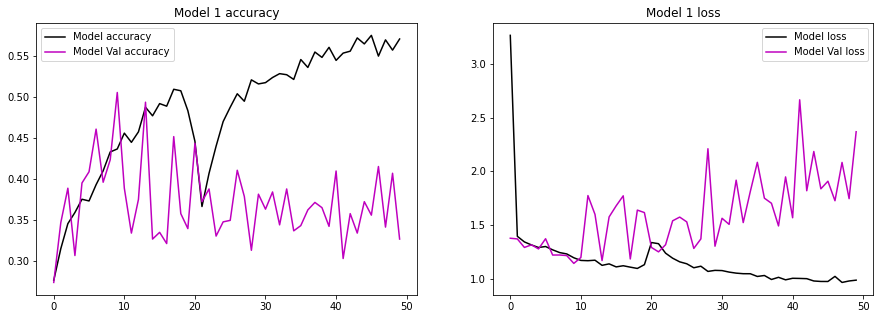

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.03573 dan Training Accuracy 54.04%
Validation Loss 2.36783 dan Validation Accuracy 32.70%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.28      0.41       933
         exc       0.62      0.76      0.68       742
         neu       0.61      0.28      0.39      1324
         sad       0.82      0.11      0.20       839

   micro avg       0.66      0.34      0.44      3838
   macro avg       0.70      0.36      0.42      3838
weighted avg       0.69      0.34      0.41      3838
 samples avg       0.34      0.34      0.34      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.07      0.01      0.01       170
         exc       0.36      0.91      0.51       299
         neu       0.70      0.08      0.15       384
         sad       0.00      0.00      0.00       245

   micro avg       0.37      0.28      0.32      1098
   macro avg       0.28      0.25      0.17      1098
weighted avg       0.35      0.28      0.19      1098
 samples avg       0.28      0.28      0.28      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


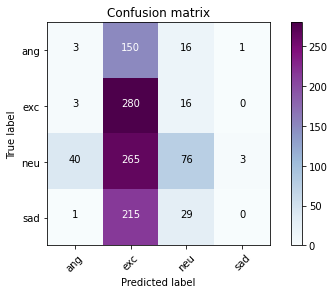

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 4**

In [ ]:
def gru_model_rot4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot4()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 1024)        65601     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1969152   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 91s 2s/step - loss: 7.3724 - accuracy: 0.2682 - val_loss: 1.4473 - val_accuracy: 0.3424
Epoch 2/50
39/39 [==============================] - 82s 2s/step - loss: 1.4471 - accuracy: 0.3262 - val_loss: 1.3984 - val_accuracy: 0.3497
Epoch 3/50
39/39 [==============================] - 84s 2s/step - loss: 1.3983 - accuracy: 0.3183 - val_loss: 1.3288 - val_accuracy: 0.2860
Epoch 4/50
39/39 [==============================] - 83s 2s/step - loss: 1.3392 - accuracy: 0.3478 - val_loss: 1.2851 - val_accuracy: 0.4599
Epoch 5/50
39/39 [==============================] - 85s 2s/step - loss: 1.2991 - accuracy: 0.3804 - val_loss: 1.2230 - val_accuracy: 0.4872
Epoch 6/50
39/39 [==============================] - 84s 2s/step - loss: 1.2831 - accuracy: 0.3880 - val_loss: 1.2359 - val_accuracy: 0.4772
Epoch 7/50
39/39 [==============================] - 84s 2s/step - loss: 1.2307 - accuracy: 0.4132 - val_loss: 1.2290 - val_accuracy: 0.4053
Epoch 8/50
39/39 [==

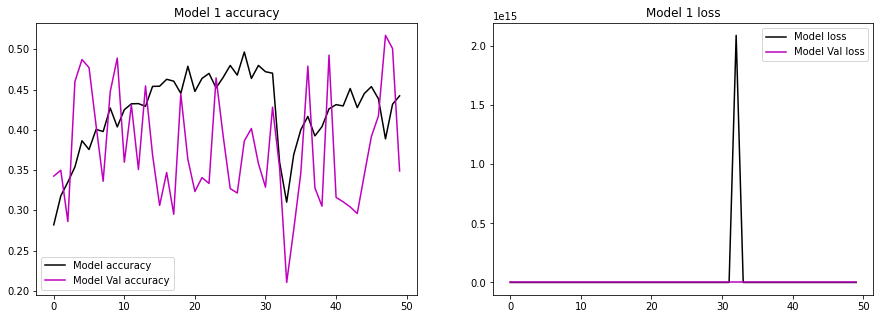

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.14516 dan Training Accuracy 45.10%
Validation Loss 1.51959 dan Validation Accuracy 34.88%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.62      0.13      0.21       933
         exc       0.82      0.42      0.55       742
         neu       0.56      0.02      0.03      1324
         sad       0.81      0.02      0.03       839

   micro avg       0.75      0.12      0.21      3838
   macro avg       0.71      0.14      0.21      3838
weighted avg       0.68      0.12      0.18      3838
 samples avg       0.12      0.12      0.12      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.23      0.10      0.14       170
         exc       0.57      0.79      0.66       299
         neu       0.57      0.02      0.04       384
         sad       0.00      0.00      0.00       245

   micro avg       0.52      0.24      0.33      1098
   macro avg       0.34      0.23      0.21      1098
weighted avg       0.39      0.24      0.22      1098
 samples avg       0.24      0.24      0.24      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


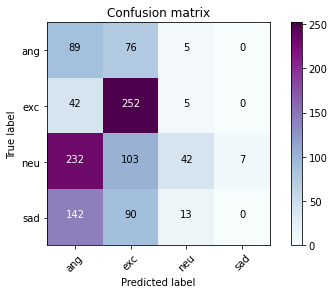

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MOCAP_COMBINED**

In [ ]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append( x_mocap )
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

(4936, 200, 189, 1)

In [ ]:
Y=[]
for ses_mod in data2:
  if ses_mod['emotion'] == 'neu':
    Y.append(0)
  elif ses_mod['emotion'] == 'ang':
    Y.append(1)
  elif ses_mod['emotion'] == 'exc':
    Y.append(2)
  elif ses_mod['emotion'] == 'sad':
    Y.append(3)


# Solving the none(1) and none(4) incompatibilty 
# Sparse takes integers as ys. Categorical takes ohe as ys. 
# In here, we map emotions to integers and later use Sparse_Categorrical ...

# emolst = ['neu','ang','exc','sad']
# emodict = dict([(b, a+b) for a, b in enumerate(sorted(set(emolst)))])
# Y = [emodict[i] for i in emolst]

# emodict = {'neu': 0, 
#            'ang': 1, 
#            'exc': 2,
#            'sad': 3,}

# emolst = [] # ['neu', 'sad'] 
# Y = [emodict[i] for i in emolst]

# print(Y)
# assert False

Y = np.array(Y)
    
# Y = label_binarize(Y,emotions_used)

print(type(Y))

Y[0]

<class 'numpy.ndarray'>


0

In [ ]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [ ]:
xtrain_mocap_combined = x_train_mocap[:3838]
xtest_mocap_combined = x_train_mocap[3838:]
ytrain_mocap_combined = Y[:3838]
ytest_mocap_combined = Y[3838:]

print(xtrain_mocap_combined.shape)
print(xtest_mocap_combined.shape)
print(type(xtrain_mocap_combined))
print(type(xtest_mocap_combined))

print(ytrain_mocap_combined.shape)
print(ytest_mocap_combined.shape)
print(type(ytrain_mocap_combined))
print(type(ytest_mocap_combined))

(3838, 200, 189, 1)
(1098, 200, 189, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3838,)
(1098,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# ytrain_mocap_combined = list(map(str, ytrain_mocap_combined))
# ytest_mocap_combined = list(map(str, ytest_mocap_combined))
# print(ytrain_mocap_combined)
# print(ytest_mocap_combined)

['neu', 'neu', 'neu', 'neu', 'ang', 'neu', 'ang', 'ang', 'sad', 'sad', 'sad', 'neu', 'sad', 'sad', 'neu', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'neu', 'sad', 'neu', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'neu', 'sad', 'sad', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu'

In [ ]:
# ytrain_mocap_combined = np.array(ytrain_mocap_combined)
# ytest_mocap_combined = np.array(ytest_mocap_combined)

In [ ]:
def simple_conv3(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same', input_shape=(200, 189, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 95, 128)      1280      
_________________________________________________________________
dropout (Dropout)            (None, 100, 95, 128)      0         
_________________________________________________________________
activation (Activation)      (None, 100, 95, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 48, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 48, 128)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 50, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 24, 128)       1

In [ ]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='wav2vec_Mocap_SGD', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 5e-5,
                         "epochs": 400,
                         "batch_size": 150,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "2D-CNN",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

wandb: Currently logged in as: ruddy. Use `wandb login --relogin` to force relogin


In [ ]:
optimizer=keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer, config.loss_fn, 
              config.metrics)

In [ ]:
hist = model.fit(xtrain_mocap_combined, ytrain_mocap_combined, 
                 batch_size=config.batch_size, epochs=config.epochs, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_combined, ytest_mocap_combined), callbacks=[WandbCallback()])

# validation_data=(xtest_mocap_combined, ytest_mocap_combined)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/400
26/26 [==============================] - 25s 443ms/step - loss: 2.5245 - acc: 0.2789 - val_loss: 1.3922 - val_acc: 0.3497
Epoch 2/400
26/26 [==============================] - 8s 319ms/step - loss: 1.4860 - acc: 0.2911 - val_loss: 1.3736 - val_acc: 0.3497
Epoch 3/400
26/26 [==============================] - 8s 321ms/step - loss: 1.4310 - acc: 0.3043 - val_loss: 1.3659 - val_acc: 0.3461
Epoch 4/400
26/26 [==============================] - 8s 322ms/step - loss: 1.4105 - acc: 0.2909 - val_loss: 1.3728 - val_acc: 0.3497
Epoch 5/400
26/26 [==============================] - 8s 326ms/step - loss: 1.4023 - acc: 0.3093 - val_loss: 1.3693 - val_acc: 0.3188
Epoch 6/400
26/26 [==============================] - 9s 329ms/step - loss: 1.3805 - acc: 0.3154 - val_loss: 1.3489 - val_acc: 0.3497
Epoch 7/400
26/26 [==============================] - 9s 332ms/step - loss: 1.3924 - acc: 0.3110 - val_loss: 1.36

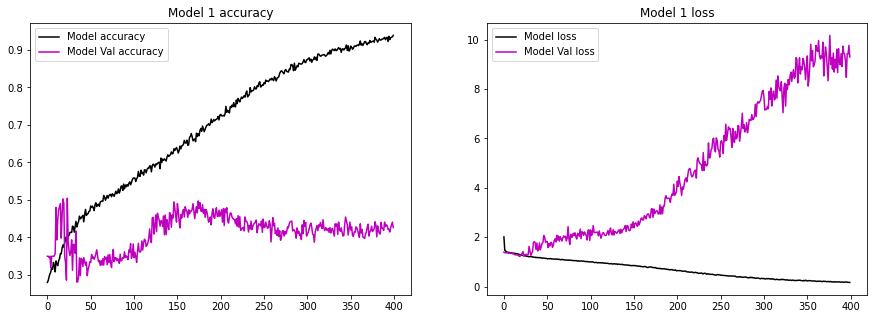

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.07819 and Training Accuracy 96.90%
Validation Loss 9.30111 and Validation Accuracy 42.62%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_combined)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_combined, labels, target_names = emotions_used))

model 1


ValueError: ignored

In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_combined)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       170
         exc       0.55      0.82      0.66       299
         neu       0.64      0.15      0.24       384
         sad       0.35      0.56      0.43       245

   micro avg       0.47      0.40      0.43      1098
   macro avg       0.38      0.38      0.33      1098
weighted avg       0.45      0.40      0.36      1098
 samples avg       0.40      0.40      0.40      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.PRGn):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.   0.43 0.19 0.38]
 [0.   0.82 0.05 0.13]
 [0.   0.21 0.3  0.48]
 [0.   0.27 0.15 0.58]]


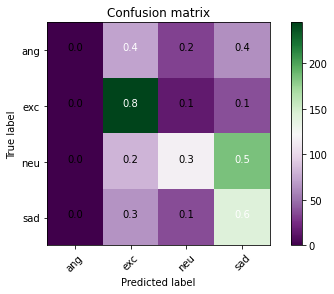

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_combined)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_combined,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

In [ ]:
model = AttentionResNet()